<div align='center'> <h1>Prospective Client Analysis By Region</h1><div>

## Introduction

In this Jupyter notebook, we will compile a regional location data set which we will use to analyze venue information from the **Foursquare** API. We will gather venue information by region which will be analyzed and visualized in order to make a suitable business decision. 


### Business Problem

A successful business owner operates a restaurant supply store. He supplies restaurants with equipment as well as cooking materials and delivers these on a schedule suitable to the restaurant’s operations. To expand his clientele, he needs to derive a list of the cities which contain the largest number of restaurants within the county in which he resides. 


In [1]:
# install required packages
!pip install lxml
!pip install BeautifulSoup4
!pip install geocoder
!pip install seaborn

# import required libs.
import pandas as pd
import geocoder
import requests # library to handle requests
from pandas.io.json import json_normalize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium 


     |████████████████████████████████| 5.5MB 7.3MB/s eta 0:00:01█████████████████████▎    | 4.7MB 7.3MB/s eta 0:00:01
     |████████████████████████████████| 122kB 5.1MB/s eta 0:00:01
     |████████████████████████████████| 102kB 9.3MB/s eta 0:00:01
     |████████████████████████████████| 829kB 6.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/d2/3d/fa76db83bf75c4f8d338c2fd15c8d33fdd7ad23a9b5e57eb6c5de26b430e/click-7.1.2-py2.py3-none-any.whl
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future


## Data 
To perform the analysis, we will use:
1.	List of cities and zip codes in Hidalgo, County
2.	Geocoders API to acquire coordinate data
3.	Foursquare API to analyze business location data. 


## Methodology
1.	Extract a list of cities by county from a web page.
2.	Gather coordinate data using geocoder api.
3.	Compile a list of businesses by location and type. 
4.	Analyze the data to determine the most profitable are within his immediate surrounding.


### Gather Regional Data


We will scrape the regional data from www.ciclt.net using the pandas library. The dataset contains regional data by City, Zip Code and County.


In [2]:

# Define the url information
url = 'http://www.ciclt.net/sn/clt/capitolimpact/gw_ziplist.aspx?ClientCode=capitolimpact&State=tx&StName=Texas&StFIPS=&FIPS=48215'
df_list = pd.read_html(url) # Read in the html data

# Extract the data table into a dataframe
df = df_list[2]

df.rename(columns={"Zip Code": "Zip"}, inplace = True)

df.head()


,Zip,City,County
0,78501,McAllen,Hidalgo County
1,78502,McAllen,Hidalgo County
2,78503,McAllen,Hidalgo County
3,78504,McAllen,Hidalgo County
4,78505,McAllen,Hidalgo County


### Add Coordinate Data

Using the **geocoder** API, we will insert the coordinates for each city and zip into the dataframe. 

In [3]:
# Add the Latitude,Longitude columns to the data set. 
df["Latitude"]  = ""
df["Longitude"] = ""
   
# Iterate over the dataframe while filling in the coordinate data. 
for index, row in df.iterrows():
    
    # init coordinate variable. 
    lat_lng_coords = None
    
    # loop until we get the coordinates. 
    while(lat_lng_coords is None):
        g = geocoder.google('{} TX, {}'.format(row['City'], row['Zip']), key='')
        lat_lng_coords = g.latlng
        
    latitude  = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
 
    df.at[index,'Latitude']  = latitude
    df.at[index,'Longitude'] = longitude

df.head()

,Zip,City,County,Latitude,Longitude
0,78501,McAllen,Hidalgo County,26.2188,-98.2322
1,78502,McAllen,Hidalgo County,26.22,-98.21
2,78503,McAllen,Hidalgo County,26.1707,-98.2541
3,78504,McAllen,Hidalgo County,26.2892,-98.2322
4,78505,McAllen,Hidalgo County,26.2,-98.23


#### Compile the Venue Data

We will use the **Foursquare** API to compile a data set of venues by city and zip. We will normalize the data and append to a top level data set which is limited to food category data. 

In [16]:
# Define Foursquare API credential variables. 

CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180604'
categoryId='4d4b7105d754a06374d81259' # limit to food category only.

# Initialize the top level dataframe variable. 
normalized = None

for index, row in df.iterrows():
   
    lat  = row['Latitude']
    lng  = row['Longitude']
    city = row['City']
    zipp = row['Zip']
    
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, categoryId)
 
    results = requests.get(url).json()
    
    city_venues = results['response']['venues']
    
    if normalized is None:
        normalized = json_normalize(city_venues)
    else:
        normalized.append(json_normalize(city_venues))
   

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:27: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


#### Examine the Normalized Data and Clean the Dataset

In [5]:
normalized.head()

,id,name,categories,referralId,hasPerk,location.address,location.crossStreet,location.lat,location.lng,location.labeledLatLngs,...,location.state,location.country,location.formattedAddress,venuePage.id,delivery.id,delivery.url,delivery.provider.name,delivery.provider.icon.prefix,delivery.provider.icon.sizes,delivery.provider.icon.name
0,4bbaae137421a593aa1ec440,Roosevelt's at 7,"[{'id': '4bf58dd8d48988d117941735', 'name': 'B...",v-1598216950,False,821 N Main St,btwn. Ivy & Hackberry,26.212032,-98.233329,"[{'label': 'display', 'lat': 26.21203186601598...",...,TX,United States,"[821 N Main St (btwn. Ivy & Hackberry), McAlle...",38119253,NaN,NaN,NaN,NaN,NaN,NaN
1,4b54ceb0f964a52064cd27e3,H-E-B,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1598216950,False,1004 N Texas Blvd,NaN,26.171035,-97.989646,"[{'label': 'display', 'lat': 26.1710347, 'lng'...",...,TX,United States,"[1004 N Texas Blvd, Weslaco, TX 78596, United ...",68090780,NaN,NaN,NaN,NaN,NaN,NaN
2,5b4639fb42d8c2002c826403,Raising Cane's Chicken Fingers,"[{'id': '4d4ae6fc7a7b7dea34424761', 'name': 'F...",v-1598216950,False,125 S Shary Rd,NaN,26.199426,-98.287284,"[{'label': 'display', 'lat': 26.199426, 'lng':...",...,TX,United States,"[125 S Shary Rd, Mission, TX 78572, United Sta...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4bca6a1efb84c9b65d381d3e,H-E-B,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",v-1598216950,False,200 US Expressway 83,NaN,26.189525,-98.225085,"[{'label': 'display', 'lat': 26.1895247, 'lng'...",...,TX,United States,"[200 US Expressway 83, McAllen, TX 78501, Unit...",68090799,NaN,NaN,NaN,NaN,NaN,NaN
4,57b0c3d9498e56f853ede513,Starbucks,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",v-1598216950,False,NaN,NaN,26.235882,-98.206453,"[{'label': 'display', 'lat': 26.23588236765852...",...,TX,United States,"[McAllen, TX, United States]",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Clean the data frame

# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in normalized.columns if col.startswith('location.')] + ['id']
hidalgo_co_venues = normalized.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
      
        return categories_list[0]['name']

# filter the category for each row
hidalgo_co_venues['categories'] = hidalgo_co_venues.apply(get_category_type, axis=1)

# clean column names by keeping only last term
hidalgo_co_venues.columns = [column.split('.')[-1] for column in hidalgo_co_venues.columns]

# Since the region is close to the border, ensure all results are in the same state. 
hidalgo_co_venues = hidalgo_co_venues[hidalgo_co_venues.state == 'TX']

# Drop rows withouth zip code data.
hidalgo_co_venues.dropna(subset = ["postalCode"], inplace=True)

hidalgo_co_venues.shape


(23, 15)

In [18]:
hidalgo_co_venues.head()

,name,categories,address,crossStreet,lat,lng,labeledLatLngs,distance,postalCode,cc,city,state,country,formattedAddress,id
0,Roosevelt's at 7,Beer Garden,821 N Main St,btwn. Ivy & Hackberry,26.212032,-98.233329,"[{'label': 'display', 'lat': 26.21203186601598...",766,78501,US,McAllen,TX,United States,"[821 N Main St (btwn. Ivy & Hackberry), McAlle...",4bbaae137421a593aa1ec440
1,H-E-B,Grocery Store,1004 N Texas Blvd,NaN,26.171035,-97.989646,"[{'label': 'display', 'lat': 26.1710347, 'lng'...",24808,78596,US,Weslaco,TX,United States,"[1004 N Texas Blvd, Weslaco, TX 78596, United ...",4b54ceb0f964a52064cd27e3
2,Raising Cane's Chicken Fingers,Fried Chicken Joint,125 S Shary Rd,NaN,26.199426,-98.287284,"[{'label': 'display', 'lat': 26.199426, 'lng':...",5907,78572,US,Mission,TX,United States,"[125 S Shary Rd, Mission, TX 78572, United Sta...",5b4639fb42d8c2002c826403
3,H-E-B,Grocery Store,200 US Expressway 83,NaN,26.189525,-98.225085,"[{'label': 'display', 'lat': 26.1895247, 'lng'...",3341,78501,US,McAllen,TX,United States,"[200 US Expressway 83, McAllen, TX 78501, Unit...",4bca6a1efb84c9b65d381d3e
4,H-E-B,Grocery Store,901 Trenton Rd,NaN,26.266437,-98.218346,"[{'label': 'entrance', 'lat': 26.267557, 'lng'...",5476,78504,US,McAllen,TX,United States,"[901 Trenton Rd, McAllen, TX 78504, United Sta...",4b6b1d9ff964a520c1f32be3


 We need to group the information by number of venues by city and zip code, we will visualize this data in order to make an appropirate decision. 

In [19]:
hidalgo_co_venues_by_zip = hidalgo_co_venues.groupby(["city", "postalCode"]).size().to_frame('count').reset_index()

hidalgo_co_venues_by_zip

,city,postalCode,count
0,Edinburg,78539,1
1,La Joya,78560,1
2,McAllen,78501,8
3,McAllen,78503,4
4,McAllen,78504,3
5,Mercedes,78570,1
6,Mission,78572,2
7,Pharr,78577,1
8,Weslaco,78596,2


### Add in the Coordinate Data

We will re-insert coordinate data for the regions which contain results. 

In [20]:

hidalgo_co_venues_by_zip["latitude"]  = ""
hidalgo_co_venues_by_zip["longitude"] = ""
   
for index, row in hidalgo_co_venues_by_zip.iterrows():
    
    # init coordinate
    lat_lng_coords = None
    
    # loop until we get the coordinates. 
    while(lat_lng_coords is None):
        g = geocoder.google('{} TX, {}'.format(row['city'], row['postalCode']), key='')
        lat_lng_coords = g.latlng
        
    latitude  = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
 
    hidalgo_co_venues_by_zip.at[index,'latitude']  = latitude
    hidalgo_co_venues_by_zip.at[index,'longitude'] = longitude

hidalgo_co_venues_by_zip.head()


,city,postalCode,count,latitude,longitude
0,Edinburg,78539,1,26.2683,-98.1885
1,La Joya,78560,1,26.247,-98.4814
2,McAllen,78501,8,26.2188,-98.2322
3,McAllen,78503,4,26.1707,-98.2541
4,McAllen,78504,3,26.2892,-98.2322


## Data Analysis

Now that the data has been compiled and cleaned, We will analyze the data using standard methods such as boxplot, and describe.

### Boxplot

<AxesSubplot:xlabel='postalCode', ylabel='count'>

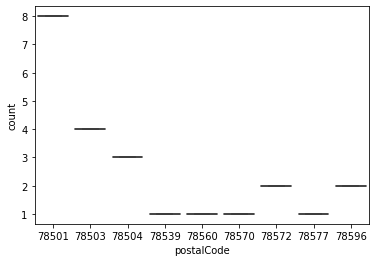

In [21]:
# Analyze 
sns.boxplot(x="postalCode", y="count", data=hidalgo_co_venues_by_zip)

### Bar Chart

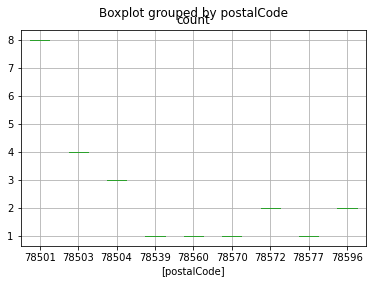

In [22]:
boxplot = hidalgo_co_venues_by_zip.boxplot(by='postalCode')

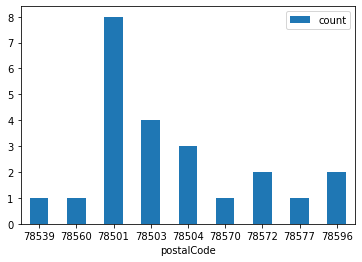

In [23]:
ax = hidalgo_co_venues_by_zip.plot.bar(x='postalCode', y='count', rot=0)

Using the describe method, we can see the percentile data for the dataframe. We will use these values to create categorical values for the dateframe's count column. 

In [24]:
hidalgo_co_venues_by_zip.describe()

,count
count,9.000000
mean,2.555556
std,2.297341
min,1.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,8.000000


In [25]:
# categorize the count data
hidalgo_co_venues_by_zip['binned'] = pd.cut(hidalgo_co_venues_by_zip['count'], bins=3, include_lowest=True, labels=['red', 'orange', 'green'])

hidalgo_co_venues_by_zip

,city,postalCode,count,latitude,longitude,binned
0,Edinburg,78539,1,26.2683,-98.1885,red
1,La Joya,78560,1,26.247,-98.4814,red
2,McAllen,78501,8,26.2188,-98.2322,green
3,McAllen,78503,4,26.1707,-98.2541,orange
4,McAllen,78504,3,26.2892,-98.2322,red
5,Mercedes,78570,1,26.1498,-97.9136,red
6,Mission,78572,2,26.2159,-98.3253,red
7,Pharr,78577,1,26.1948,-98.1836,red
8,Weslaco,78596,2,26.1595,-97.9908,red


## Data Visualization

We will use the folium library to visualize the categorized data and determine the best prospective region for client expansion. 

In [26]:
# map results
latitude  = 26.4656
longitude = -98.2213

hidalgo_co = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, label, color, pc in zip(hidalgo_co_venues_by_zip.latitude, hidalgo_co_venues_by_zip.longitude, hidalgo_co_venues_by_zip.city, hidalgo_co_venues_by_zip.binned, hidalgo_co_venues_by_zip.postalCode ):
    folium.features.CircleMarker(
        [lat, lng],
        radius=4,
        color= color,
        popup=label + " " + pc,
        fill = True,
        fill_color=color,
        fill_opacity=0.6
    ).add_to(hidalgo_co)
    
hidalgo_co

## Results

Based on the data analysis we can determine that the best region to gain new clients is in the **McAllen** area, specifically in the **78501** postal code which contains 8 businesses listed in the **Foursquare** API. Even though the location data is limited for my region, we can easily apply the analysis to a larger metropolitan area by adjusting the parameters to fit the model for a larger city.   


## Conclusion


Using the techniques learned in the Data Science with Python course, We have: 


1. Scraped Data from an exisiting source using Pandas library.
2. Cleaned the dataframe so that it is suitable for data analysis. 
3. Integrated a third party location api to compile a list of regional venues. 
4. Analyzed the compiled data to extract information that can be valuable when making business decisions. 

    